# 1. Import modules

In [1]:
import json
import numpy as np
import random
import sys
import time
import cv2
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense,Flatten,Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

Using TensorFlow backend.


# 2. Download and study the dataset

### Load data

In [2]:
with open ('/Users/howard/Desktop/ECE228/Project/Data/shipsnet.json') as f:
    dataset=json.load(f)
data_images=np.array(dataset['data']).astype('uint8')
data_labels=np.array(dataset['labels']).astype('uint8')

In [3]:
data_images.shape

(2800, 19200)

The dataset contains 2800 images, each of which is represented as a vector of length 19200 elements. 

In [4]:
data_labels.shape

(2800,)

In [5]:
print(list(data_labels).count(0))
print(list(data_labels).count(1))

2100
700


The dataset contains 700 positive samples labeled as 1, and 2100 negative samples labeled as 0.

### Visualize one image

In [6]:
# Convert vectors in data_images into RGB matrix
n_chanels=3
height=80
width=80
X=data_images.reshape([-1,n_chanels,height,width])
print(X.shape)
print(X[0].shape)

(2800, 3, 80, 80)
(3, 80, 80)


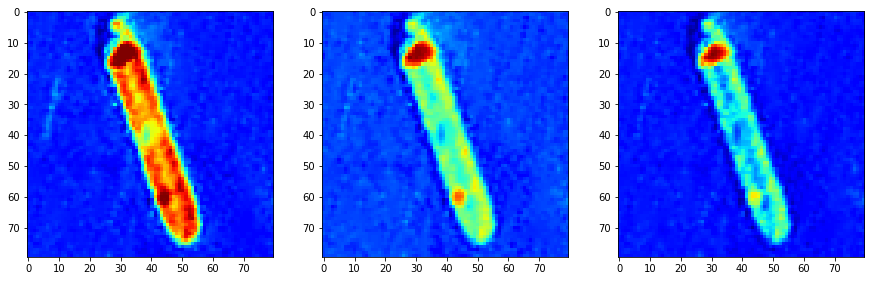

In [7]:
# Visualize
pic=X[0]
red_chanel=pic[0]
green_chanel=pic[1]
blue_chanel=pic[2]

plt.figure(figsize=(5*3, 5*1))
plt.set_cmap('jet')

plt.subplot(131)
plt.imshow(red_chanel)

plt.subplot(132)
plt.imshow(green_chanel)

plt.subplot(133)
plt.imshow(blue_chanel)

plt.show()

# 3. Binary-Classification Algorithms Comparison

### Split the dataset

In [8]:
x_train,x_test,y_train,y_test=train_test_split(data_images,data_labels,test_size=0.2,random_state=42)

### Comparison using sklearn


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.875893 (0.025707)
RF: 0.930804 (0.010981)
KNN: 0.921429 (0.012969)
SVM: 0.750893 (0.035926)


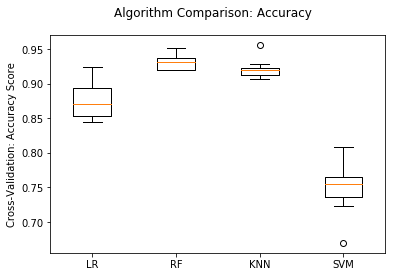

LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine
-2004.7705228328705


In [9]:
start=time.time()
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)

def defineModels():
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine')
    return
defineModels()
end=time.time()
print(end-start)

# 4. Convolutional Neural Network Implementation

### Data Preprocessing

In [10]:
# Convert data_labels into onehotcode
Y=np_utils.to_categorical(data_labels,2)
print(Y.shape)
print(Y)

(2800, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [11]:
# Shuffle
indexes = np.arange(2800)
np.random.shuffle(indexes)
X=X[indexes].transpose([0,2,3,1])
Y=Y[indexes]

In [12]:
# Normalization
X=X/255

### Train Convolutional Neural Network

In [13]:
np.random.seed(42)

In [14]:
# Design Network
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [15]:
# Optimization Setup
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0,amsgrad=False),
    metrics=['accuracy'])
# training
history=model.fit(
    X,
    Y,
    batch_size=32,
    epochs=32,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 2240 samples, validate on 560 samples
Epoch 1/32
 - 26s - loss: 0.5775 - acc: 0.7522 - val_loss: 0.3172 - val_acc: 0.8839
Epoch 2/32
 - 25s - loss: 0.3063 - acc: 0.8786 - val_loss: 0.3591 - val_acc: 0.8893
Epoch 3/32
 - 25s - loss: 0.2268 - acc: 0.9129 - val_loss: 0.2013 - val_acc: 0.9071
Epoch 4/32
 - 24s - loss: 0.1766 - acc: 0.9317 - val_loss: 0.1668 - val_acc: 0.9304
Epoch 5/32
 - 25s - loss: 0.1425 - acc: 0.9451 - val_loss: 0.1221 - val_acc: 0.9500
Epoch 6/32
 - 24s - loss: 0.1122 - acc: 0.9598 - val_loss: 0.1148 - val_acc: 0.9536
Epoch 7/32
 - 24s - loss: 0.1186 - acc: 0.9576 - val_loss: 0.1062 - val_acc: 0.9589
Epoch 8/32
 - 23s - loss: 0.0906 - acc: 0.9625 - val_loss: 0.0818 - val_acc: 0.9661
Epoch 9/32
 - 24s - loss: 0.0927 - acc: 0.9647 - val_loss: 0.0877 - val_acc: 0.9696
Epoch 10/32
 - 28s - loss: 0.0923 - acc: 0.9656 - val_loss: 0.0867 - val_acc: 0.9643
Epoch 11/32
 - 25s - loss: 0.0699 - acc: 0.9754 - val_loss: 0.0803 - val_acc: 0.9607
Epoch 12/32
 - 25s - loss: 

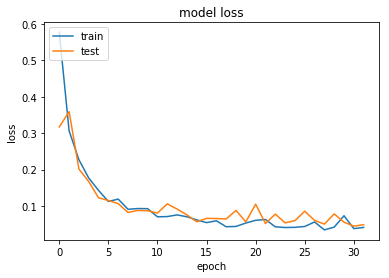

In [16]:
# Plot Loss Curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

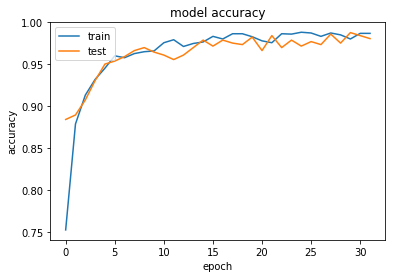

In [17]:
# Plot Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Ship Detection Combining CNN with Sliding Window

### Download image

In [18]:
image=cv2.imread('/Users/howard/Desktop/ECE228/Project/Data/scenes/sfbay_1.png',flags=cv2.IMREAD_COLOR)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [19]:
width=image.shape[0]
height=image.shape[1]

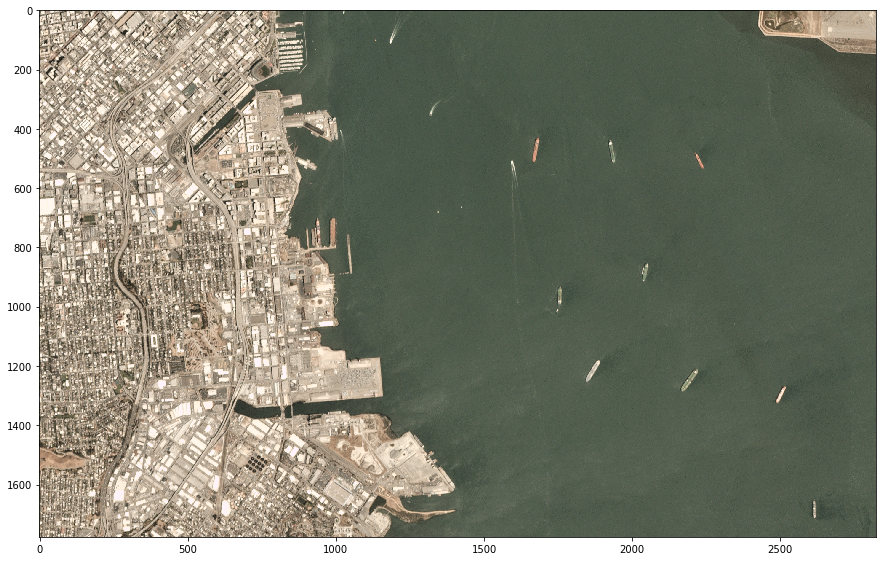

In [20]:
# Visualize
plt.figure(1, figsize = (15, 30))

plt.imshow(image)

plt.show()

In [21]:
image.shape
print(type(image))

<class 'numpy.ndarray'>


In [22]:
image=image.transpose(2,0,1)
image= np.array(image).astype('uint8')

In [23]:
image.shape

(3, 1777, 2825)

### Search on the image

In [24]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = image[0][y+i][x+j]
            area_study[1][i][j] = image[1][y+i][x+j]
            area_study[2][i][j] = image[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [25]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [26]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                image[ch][y+th+80][x+i] = -1

X:820 Y:10  [[ 0.02753091  0.97246909]]


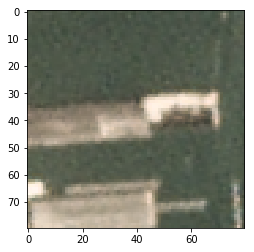

X:1640 Y:410  [[ 0.059073    0.94092703]]


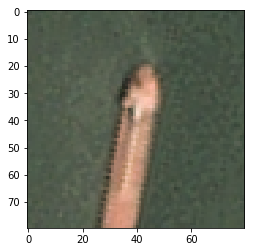

X:1560 Y:500  [[ 0.0685747   0.93142527]]


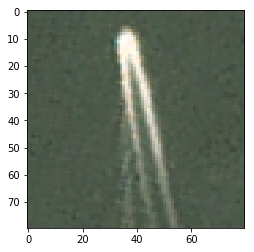

X:950 Y:690  [[  8.59308988e-04   9.99140620e-01]]


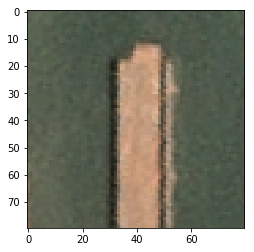

X:1020 Y:1150  [[ 0.04934238  0.95065767]]


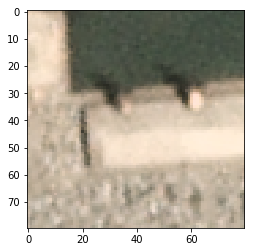

X:1280 Y:1650  [[ 0.02284519  0.97715479]]


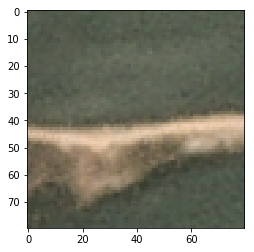

X:1690 Y:1690  

IndexError: index 1777 is out of bounds for axis 0 with size 1777

In [27]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [28]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [29]:
image=image.transpose(1,2,0)
image.shape

(1777, 2825, 3)

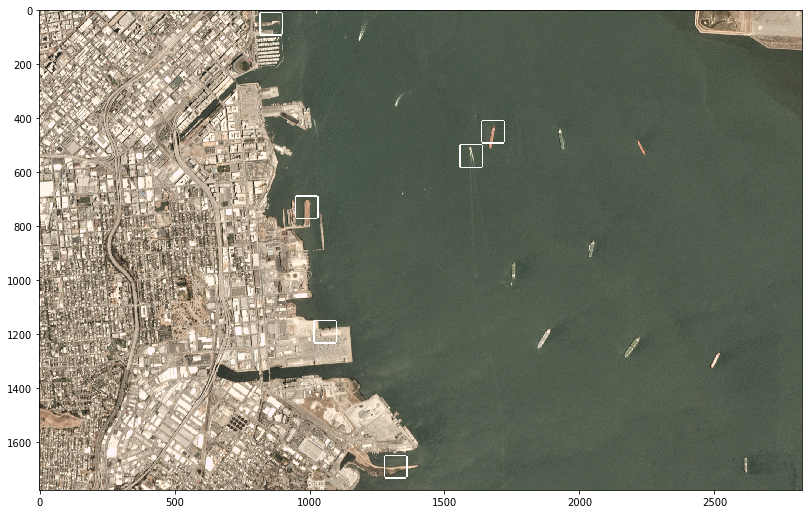

In [31]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(image)

plt.show()